# 2018-02-16 / FMA sub-sampling mk2

* In case entrofy is too slow / doesn't work out, we'll make a backup sampler
* Requirements:
    * subsample of size N
    * for each instrument, at least K positives

# 2018-30-15 / Updates

* License filtering: CC only
* Sampling: 50/50 from 80/20 per instrument

In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import gzip

In [2]:
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
# Filter down to the set with valid licenses

df_valid = pd.read_csv('/home/bmcfee/data/cc_tracks.csv.gz', usecols=[0])['track_id']
df_valid = df_valid.apply(lambda x: '{:06d}'.format(x))

In [5]:
valid_set = set(df_valid)

In [10]:
df = pd.read_csv('/home/bmcfee/data/vggish-likelihoods-a226b3-maxagg10.csv.gz', index_col=0)

In [11]:
df = df.drop([x for x in tqdm(df.index) if x[:6] not in valid_set])

HBox(children=(IntProgress(value=0, max=29620525), HTML(value='')))

In [12]:
df.head(5)

,accordion,bagpipes,banjo,bass,cello,clarinet,cymbals,drums,flute,guitar,...,mandolin,organ,piano,saxophone,synthesizer,trombone,trumpet,ukulele,violin,voice
000002_0000,0.01542,0.008608,0.010215,0.035007,0.008873,0.00893,0.086853,0.671350,0.021807,0.135010,...,0.006079,0.011073,0.084341,0.015115,0.781432,0.012166,0.025021,0.044818,0.067646,0.999691
000002_0001,0.01542,0.008608,0.010215,0.076214,0.008873,0.00893,0.086853,0.630533,0.021807,0.244505,...,0.006079,0.011073,0.084341,0.015115,0.781432,0.012166,0.025021,0.044818,0.067646,0.999691
000002_0002,0.01542,0.008608,0.010215,0.076214,0.008873,0.00893,0.089177,0.858667,0.021807,0.244505,...,0.006079,0.011073,0.084341,0.015115,0.188291,0.012166,0.025021,0.044818,0.067646,0.999691
000002_0003,0.01542,0.008608,0.010215,0.076214,0.004974,0.00893,0.089177,0.858667,0.012667,0.244505,...,0.003388,0.009051,0.040380,0.009120,0.131694,0.005950,0.014247,0.044818,0.067646,0.999691
000002_0004,0.01542,0.008608,0.009334,0.076214,0.004974,0.00893,0.089177,0.858667,0.012667,0.244505,...,0.003388,0.017866,0.078745,0.009120,0.204007,0.005950,0.014247,0.028634,0.088025,0.999691


# Algorithm
- For each instrument, split at the *QUANTILE* by likelihood
- Skip tracks that have already appeared
- Take *BALANCE* samples uniformly from above the quantile, and *1-BALANCE* from below.
- Handle instruments by increasing order of median likelihood

In [34]:
K = 1000
N = K * 23

BALANCE = 0.5
QUANTILE = 0.8

In [16]:
dfm = df.median(axis=0)

In [21]:
inst_order = dfm.sort_values().index

In [22]:
inst_order

Index(['banjo', 'mandolin', 'harp', 'clarinet', 'bagpipes', 'accordion',
       'harmonica', 'ukulele', 'trombone', 'trumpet', 'cello', 'saxophone',
       'flute', 'organ', 'mallet_percussion', 'cymbals', 'violin', 'piano',
       'bass', 'synthesizer', 'guitar', 'drums', 'voice'],
      dtype='object')

In [24]:
idx_inst = df[inst_order[0]].sort_values(ascending=False).index

In [26]:
len(idx_inst)

29475739

In [36]:
pos_thresh

5895147

In [38]:
idx_pos = idx_inst[:pos_thresh]

In [39]:
np.random.permutation(idx_pos)

array(['086777_0485', '136517_0405', '118261_0098', ..., '099490_0069',
       '108040_0184', '091533_0020'], dtype=object)

In [40]:
rng = np.random.RandomState(20180315)

In [41]:
idx_set = set()
track_set = set()


N_ABOVE = int(BALANCE * K)
N_BELOW = int(K * (1 - BALANCE))

pos_thresh = int((1 - QUANTILE) * len(idx_inst))

for col in tqdm(inst_order):

    # This gives a descending sort of the instruments by likelihood
    idx_inst = df[col].sort_values(ascending=False).index
    
    # Get the top quantile
    idx_pos = idx_inst[:pos_thresh]

    # Randomly permute
    idx_pos = rng.permutation(idx_pos)
    
    count = 0
    
    # Make a uniform selection within the top 
    for v in idx_pos:
        track, seg = v.split('_', maxsplit=1)
        
        if track in track_set:
            continue
            
        idx_set.add(v)
        track_set.add(track)
        count += 1
        
        if count == N_ABOVE:
            break
            
    # Get the bottom quantile
    idx_neg = idx_inst[pos_thresh:]

    # Randomly permute
    idx_neg = rng.permutation(idx_neg)
    
    count = 0
    
    # Make a uniform selection within the top 
    for v in idx_neg:
        track, seg = v.split('_', maxsplit=1)
        
        if track in track_set:
            continue
            
        idx_set.add(v)
        track_set.add(track)
        count += 1
        
        if count == N_BELOW:
            break

HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

In [42]:
df_sample = df.loc[idx_set]

In [43]:
df_sample.describe()

,accordion,bagpipes,banjo,bass,cello,clarinet,cymbals,drums,flute,guitar,...,mandolin,organ,piano,saxophone,synthesizer,trombone,trumpet,ukulele,violin,voice
count,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,...,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000
mean,0.029255,0.023260,0.015367,0.173789,0.053562,0.014728,0.098883,0.592259,0.062435,0.607389,...,0.015870,0.074887,0.163819,0.052172,0.323989,0.035277,0.040471,0.038279,0.180095,0.706060
std,0.083442,0.078448,0.046022,0.109676,0.110997,0.032556,0.084778,0.292617,0.121498,0.295856,...,0.042100,0.106242,0.145217,0.111789,0.250389,0.075214,0.077221,0.074948,0.216622,0.302039
min,0.000045,0.000001,0.000023,0.004175,0.000099,0.000018,0.000051,0.000857,0.000106,0.015541,...,0.000026,0.000313,0.001630,0.000211,0.000772,0.000026,0.000041,0.000056,0.000920,0.009486
25%,0.004100,0.002873,0.002035,0.095061,0.009889,0.003024,0.040457,0.359092,0.011115,0.347581,...,0.002347,0.019007,0.072076,0.012192,0.094710,0.007483,0.009302,0.005621,0.052565,0.445858
50%,0.008987,0.007126,0.005523,0.155269,0.018799,0.007594,0.077496,0.618647,0.025247,0.594905,...,0.005667,0.038444,0.129258,0.022343,0.283141,0.014437,0.018510,0.014002,0.098506,0.822120
75%,0.021172,0.017086,0.014643,0.228218,0.039830,0.015419,0.133859,0.866923,0.056738,0.919674,...,0.013670,0.084713,0.205593,0.041616,0.512114,0.030147,0.036996,0.038473,0.205518,0.987816
max,0.986288,0.998995,0.948913,0.908077,0.916733,0.911034,0.942885,0.998915,0.985745,0.999668,...,0.831260,0.959128,0.963889,0.961027,0.955806,0.916121,0.923414,0.901138,0.998601,0.999985


In [45]:
import json

In [46]:
with open('../notebooks/subsample_idx_greedy_balanced.json', 'w') as fd:
    json.dump(list(idx_set), fd, indent=2)

---
## Figures

In [47]:
Xs = df_sample.values

In [48]:
np.cov(Xs.T)

array([[  6.96254550e-03,   1.45497710e-03,   4.12710597e-04,
         -8.93825531e-04,   1.08590513e-03,   6.19326386e-04,
         -6.23210306e-04,  -3.53338284e-03,   9.17504658e-04,
         -2.46627778e-03,   2.84848454e-03,   1.08697529e-04,
          1.04468146e-04,   3.29697307e-04,   1.88698075e-03,
          1.25071921e-03,   1.92762309e-03,  -2.67024991e-04,
          1.20028381e-03,   1.59591236e-03,   3.93465396e-04,
          6.10405226e-03,  -6.09126200e-04],
       [  1.45497710e-03,   6.15401596e-03,   6.67309089e-05,
         -9.19046570e-04,   4.35996037e-04,   3.56584930e-04,
         -3.03378794e-04,  -1.74967307e-03,   9.78512857e-04,
         -2.31534126e-03,   1.73737747e-03,  -6.17947636e-05,
          3.97963258e-04,   8.26004410e-05,   8.48378161e-04,
          1.47315439e-04,   6.49472504e-04,   6.65037256e-05,
          4.56842625e-04,   9.24793631e-04,  -7.37394724e-05,
          5.03438336e-03,  -3.96409622e-04],
       [  4.12710597e-04,   6.67309089e-05

In [49]:
import matplotlib.pyplot as plt
%matplotlib nbagg

In [50]:
#C = np.cov(Xs.T)

In [51]:
C = df_sample.corr()
Co = df.corr()

<IPython.core.display.Javascript object>


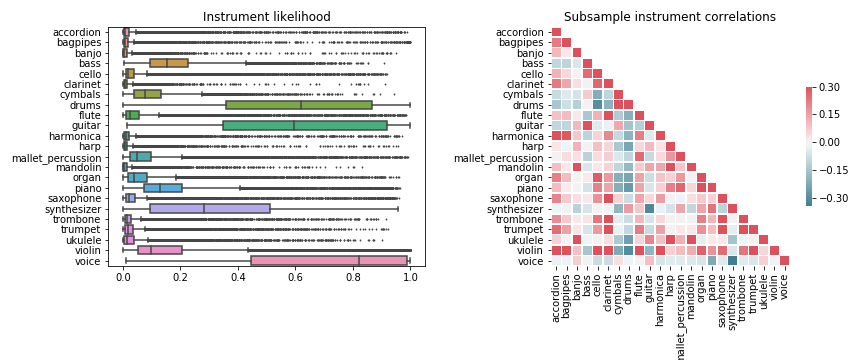

In [54]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
#sns.pointplot(data=df_sample, orient='h', join=False, markers='o', capsize=1, )
sns.boxplot(data=df_sample, orient='h', fliersize=1)

plt.title('Instrument likelihood')
plt.ylim([-0.5, 22.5])
plt.gca().invert_yaxis()

plt.subplot(1,2,2)

mask = np.zeros_like(C, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(C, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Subsample instrument correlations')
plt.tight_layout()

<IPython.core.display.Javascript object>


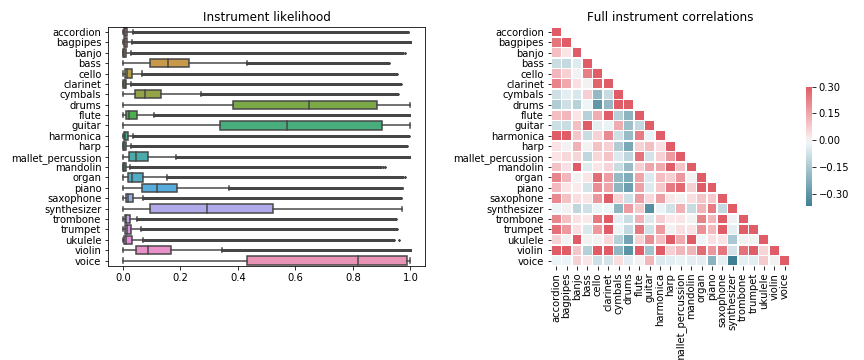

In [55]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
#sns.pointplot(data=df, orient='h', join=False, markers='o', capsize=1, )
sns.boxplot(data=df, orient='h', fliersize=1)

plt.title('Instrument likelihood')
plt.ylim([-0.5, 22.5])
plt.gca().invert_yaxis()

plt.subplot(1,2,2)

mask = np.zeros_like(Co, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(Co, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Full instrument correlations')
plt.tight_layout()

---
# Cruft

In [48]:
idx_set = set()
track_set = set()

for col in tqdm(dfm.sort_values().index):

    # This gives a descending sort of the instruments by likelihood
    idx_inst = df[col].sort_values(ascending=False).index
    
    count = 0
    
    # Make a uniform selection within the top 
    for v in idx_inst:
        track, seg = v.split('_', maxsplit=1)
        
        if track in track_set:
            continue
            
        idx_set.add(v)
        track_set.add(track)
        count += 1
        
        if count == K:
            break

HBox(children=(IntProgress(value=0, max=23), HTML(value='')))